In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Apr 29 15:24:12 2023

@author: Team 5
"""

import numpy as np
import matplotlib.pyplot as plt

#import qiskit functionality
from qiskit.circuit.quantumregister import QuantumRegister
from qiskit.circuit.quantumcircuit import QuantumCircuit
from qiskit.circuit.library.standard_gates import HGate, CZGate, RYGate

#from RBS_gate import RBSGate


from qiskit import Aer

# Adding the transpiler to reduce the circuit to QASM instructions
# supported by the backend
from qiskit import transpile

# Use AerSimulator
from qiskit_aer import AerSimulator

### Enable Hardware:

From helper ipynb:

If you are not planning to submit jobs to quantum computers, this notebook should work well with `Python [Default]` kernel. If you want to submit jobs to quantum computers, make sure that you have installed the qiskit environment on qBraid ([installation instructions](https://qbraid-qbraid.readthedocs-hosted.com/en/latest/lab/environments.html#install-environment)) and have selected the `Python [Qiskit]` kernel (Menu Bar->Kernel->Change Kernel).

If you do not have aws credentials for submitting your quantum jobs, you will need qBraid-Credits. If you have qBraid-Credits, you can run the following line of code to submit quantum jobs through qBraid

In [2]:
!qbraid jobs enable qiskit

You have already enabled qBraid Quantum Jobs in the qiskit environment.


In [5]:
RUN_BACKEND = 1 # 0 = simulator, 1 = Hardware, 2 = Unitary


# convert normalized vector to spherical variables
def angles(x, V = True):
    n = len(x)
    theta = np.zeros(n-1)
    
    for i in range(n-1):
        if i==0:
            theta[i] = np.arccos(x[i])
        else:
            tmp = x[i]
            for j in range(i):
                tmp *= 1/np.sin(theta[j])
            theta[i] = np.arccos(tmp)
            
    ### for checking correctness:
    if V:
        print("The following two should equal: ")
        print(x[-1])
        tmp = 1
        for i in range(n-1):
            tmp*=np.sin(theta[i])
        print(tmp)
        
    
    return theta









In [7]:
if __name__ == '__main__':
    n_q = 4
    n_shots = 10000
    
    # Create a quantum circuit with four qubits
    qr = QuantumRegister(n_q)
    qc = QuantumCircuit(qr)


    thetas = angles(np.ones(n_q)/np.sqrt(n_q), V = False)
    #thetas = np.ones(n_q)*np.pi/4 * 2
    
    #prepares initial state: 1110 (corresponds to simple driangle)
    qc.x(0)
    qc.x(1)
    qc.x(2)
    
    qc.barrier(range(n_q))

    
    #builds the circuit, fig. 2 from https://arxiv.org/pdf/2202.00054.pdf
    for ind, j in enumerate(range(2, n_q+1)):
        i = n_q-j
        qr_pair = [qr[i], qr[i+1]]
        

    
        param = thetas[::-1][ind]
        
        
        # TODO: Implement this such that transpilation works...
        #qc.append(RBSGate(param=param), [qr[i], qr[i+1]])


        
        
        # Apply RBS gate:
        qc.append(HGate(), [qr[i]])
        qc.append(HGate(), [qr[i+1]])
        # Apply a two qubit CZ gate
        qc.append(CZGate(), [qr[i], qr[i+1]])
        # Apply RY of pi.2 on both qubits
        qc.append(RYGate(-param), [qr[i]]) # note sign convention
        qc.append(RYGate(param), [qr[i+1]])
        # Apply a two qubit CZ gate
        qc.append(CZGate(), [qr[i], qr[i+1]])
        # Apply Hadamard on both qubits
        qc.append(HGate(), [qr[i]])
        qc.append(HGate(), [qr[i+1]])
        

        
    qc.x(0)

    for ind, j in enumerate(range(2, n_q+1)):
        i = j-2

        qr_pair = [qr[i], qr[i+1]]
        
        #TODO - remove
        #qc = apply_RBS(qc, qr_pair, thetas[i])
    
        param = -thetas[ind]
        

        
        qc.append(HGate(), [qr[i]])
        qc.append(HGate(), [qr[i+1]])
        # Apply a two qubit CZ gate
        qc.append(CZGate(), [qr[i], qr[i+1]])
        # Apply RY of pi.2 on both qubits
        qc.append(RYGate(-param), [qr[i]]) 
        qc.append(RYGate(param), [qr[i+1]])
        # Apply a two qubit CZ gate
        qc.append(CZGate(), [qr[i], qr[i+1]])
        # Apply Hadamard on both qubits
        qc.append(HGate(), [qr[i]])
        qc.append(HGate(), [qr[i+1]])


    

    
    
    
    # Run the circuit
    if RUN_BACKEND == 0:
        # Sample from the circuit
        meas = QuantumCircuit(n_q, n_q)
        meas.barrier(range(n_q))
        # map the quantum measurement to the classical bits
        meas.measure(range(n_q), range(n_q))
        
        # append the measurement to our circuit
        qc = meas.compose(qc, range(n_q), front=True)
        
        
        
        
        backend = AerSimulator()
       
        # First we have to transpile the quantum circuit
        # to the low-level QASM instructions used by the
        # backend
        qc_compiled = transpile(qc, backend)
    
        
        # Execute the circuit on the qasm simulator.
        # We've set the number of repeats of the circuit
        # to be 1024, which is the default.
        job_sim = backend.run(qc_compiled, shots=n_shots)
        
        # Grab the results from the job.
        result_sim = job_sim.result()
        
        
        
        
        counts = result_sim.get_counts(qc_compiled)
        print(counts)
        
        #from qiskit.visualization import plot_histogram
        #plot_histogram(counts)

    
    if RUN_BACKEND ==1: #run on real hardware
        # Sample from the circuit
        meas = QuantumCircuit(n_q, n_q)
        meas.barrier(range(n_q))
        # map the quantum measurement to the classical bits
        meas.measure(range(n_q), range(n_q))
        
        # append the measurement to our circuit
        qc = meas.compose(qc, range(n_q), front=True)
        
        
            
 
        
        from qiskit_ibm_runtime import QiskitRuntimeService
        service = QiskitRuntimeService(channel="ibm_quantum")

        options = {
            "backend_name": 'ibmq_guadalupe', 
            "max_execution_time":300,
            "instance":'ibm-q-startup/qbraid/reservations' #"reservations" instead of "main"
           }

        runtime_inputs = {
            'circuits': qc, 
            'shots': n_shots, 
        }
        
        job = service.run(
            program_id='circuit-runner',
            options=options,
            inputs=runtime_inputs,
        )
        
        
        
        
    if RUN_BACKEND == 2:
        backend = Aer.get_backend('unitary_simulator')
        
               
        # First we have to transpile the quantum circuit
        # to the low-level QASM instructions used by the
        # backend
        qc_compiled = transpile(qc, backend)
    
        
        # Execute the circuit on the qasm simulator.
        # We've set the number of repeats of the circuit
        # to be 1024, which is the default.
        job_sim = backend.run(qc_compiled, shots=n_shots)
        
        result = job_sim.result()
        print(np.real(result.get_unitary(qc ,3).data))

        
        
        

In [22]:
# check status:

job.status()


<JobStatus.DONE: 'job has successfully run'>

In [23]:
print(job.logs())
print(job.job_id())

"2023-04-29T11:40:04.883627658Z Setting up watches.\n2023-04-29T11:40:04.883627658Z Watches established.\n2023-04-29T11:40:06.260481680Z INFO:     Started server process [7]\n2023-04-29T11:40:06.260481680Z INFO:     Waiting for application startup.\n2023-04-29T11:40:06.260576959Z INFO:     Application startup complete.\n2023-04-29T11:40:06.261417812Z INFO:     Uvicorn running on http://127.0.0.1:8081 (Press CTRL+C to quit)\n2023-04-29T11:44:01.410855652Z INFO:     127.0.0.1:55098 - \"POST /run HTTP/1.1\" 202 Accepted\n2023-04-29T11:44:01.448592041Z programruntime.runtime_provider - DEBUG QuantumProgramProvider initialization completed. Program ID=circuit-runner, execution ID=ch6g0dppleju569s2rk0, hub=ibm-q-startup, group=qbraid, project=reservations, Session ID=None.\n2023-04-29T11:44:01.448918349Z programruntime.program_starter_wrapper - INFO Executing program.py (job ch6g0dppleju569s2rk0)\n2023-04-29T11:44:01.459395612Z stevedore._cache - DEBUG reading /opt/app-root/src/.cache/python

In [24]:
result = job.result()


In [35]:
counts = result.get_counts()


In [36]:
counts

{'0000': 135,
 '0001': 745,
 '0010': 515,
 '0011': 2004,
 '0100': 277,
 '0101': 1920,
 '0110': 1105,
 '0111': 635,
 '1000': 133,
 '1001': 320,
 '1010': 184,
 '1011': 429,
 '1100': 126,
 '1101': 335,
 '1110': 196,
 '1111': 941}

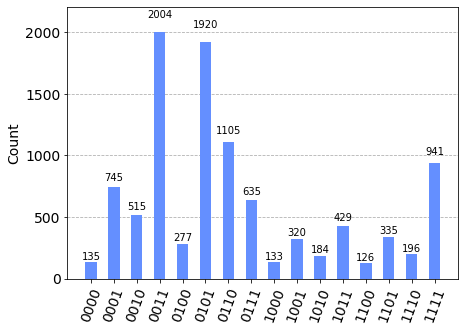

In [37]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)